# Билет №30

In [1]:
import copy
import random  # noqa
import typing as t
from pathlib import Path

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [2]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [3]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [4]:
DATA_DIR = Path("../data/")

CUDA = "cuda"
CPU = "cpu"
DEVICE = CUDA if torch.cuda.is_available() else CPU
print(f"Using {DEVICE.upper()} device")

Using CUDA device


## Задача 2

CNN для классификации изображений.

Датасет: `images/fruits`

### Предобработка данных и подготовка датасета

In [5]:
def torch_train_test_split(dataset: t.Union[Dataset, t.Sized], test_size: float) -> t.Tuple[Subset, Subset]:
    test_size = round(test_size * len(dataset))
    train_size = len(dataset) - test_size
    train_dataset, test_dataset = random_split(dataset, lengths=(train_size, test_size))
    return train_dataset, test_dataset

Начальные картинки размера 100x100, уменьшу их и сохраню на диск, чтобы ускорить обучение в эпохах.

In [6]:
base_transform = transforms.Compose([
    transforms.Resize(size=(48, 48)),
])

fruits_dataset = ImageFolder(DATA_DIR / "images/fruits", transform=base_transform)
save_dir = DATA_DIR / "images/fruits_48"
save_dir.mkdir(exist_ok=True)
for cls in fruits_dataset.classes:
    (save_dir / cls).mkdir(exist_ok=True)

for i in tqdm(range(len(fruits_dataset))):
    img, target = fruits_dataset[i]
    img.save(save_dir / fruits_dataset.classes[target] / Path(fruits_dataset.imgs[i][0]).name)

fruits_dataset = ImageFolder(save_dir)  # картинки размера 48x48

100%|██████████| 2677/2677 [00:11<00:00, 231.07it/s]


Задача классификации фруктов на изображении. 6 классов, классы относительно сбалансированы.

Strawberry Wedge    496
Redcurrant          492
Pineapple Mini      450
Strawberry          450
Raspberry           420
Pineapple           369
dtype: int64


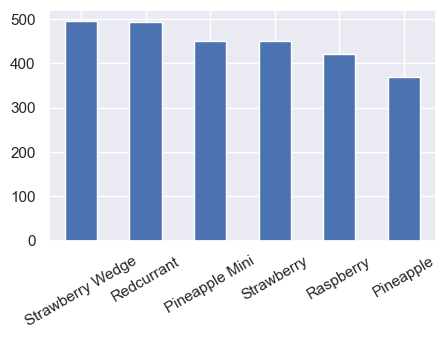

In [7]:
vc = pd.value_counts(fruits_dataset.targets)
vc.index = [fruits_dataset.classes[i] for i in vc.index]
print(vc)
vc.plot.bar(rot=30, figsize=(5, 3));

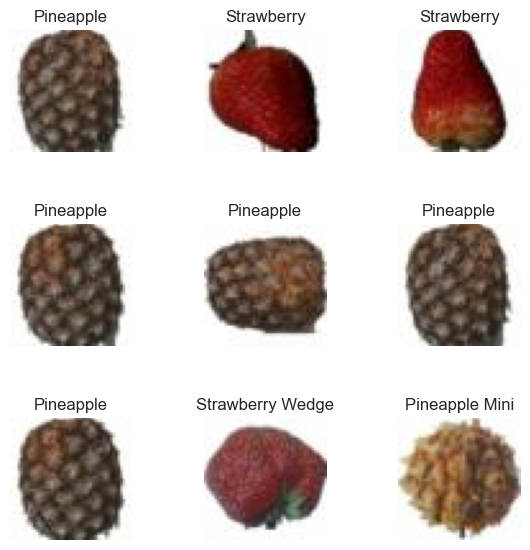

In [8]:
torch.manual_seed(0)  # буду использовать везде, что воспроизводить результаты

fig, axes = plt.subplots(3, 3, figsize=(6, 6))
fig.tight_layout()
for i, ax in zip(torch.randperm(len(fruits_dataset)), axes.flatten()):
    img, target = fruits_dataset[i]
    ax.axis("off")
    ax.set_title(fruits_dataset.classes[target])
    ax.imshow(img)

Разделим выборку на тренировочную и тестовую. Тренировочную выборку расширим за счет аугментации (аугментация будет применяться во время обучения):

In [9]:
torch.manual_seed(0)

train_transform = transforms.Compose([
    *base_transform.transforms,
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomVerticalFlip(p=0.25),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.ToTensor(),
    # можно рассчитать, можно взять общепринятые, можно взять по 0.5
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])
test_transform = transforms.Compose([
    *base_transform.transforms,
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

train_dataset, test_dataset = torch_train_test_split(fruits_dataset, test_size=0.2)
# не очень красиво, но работает - подменяем трансформации для каждой выборки на нужные:
train_dataset.dataset = copy.deepcopy(train_dataset.dataset)
train_dataset.dataset.transform = train_transform
test_dataset.dataset = copy.deepcopy(test_dataset.dataset)
test_dataset.dataset.transform = test_transform

len(train_dataset), len(test_dataset)

(2142, 535)

### Построение и обучение модели

Немного шаблонного кода для обучения модели:

In [10]:
def get_weights(targets: torch.Tensor) -> torch.Tensor:
    _, counts = targets.unique(return_counts=True)
    return counts.max() / counts


def common_train(  # основной цикл обучения модели
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        epochs: int,
        train_dataloader: DataLoader,
        test_dataloader: DataLoader,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[t.List[float], t.List[float], t.List[float], t.List[float]]:
    train_losses, train_accuracy_list = [], []
    test_losses, test_accuracy_list = [], []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)

        train_loss, train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer, verbose, device)
        print(f"Train Error: loss: {train_loss:.6f}, accuracy: {train_accuracy:.4f}")
        train_losses.append(train_loss)
        train_accuracy_list.append(train_accuracy)

        # будем считать оценки на тестовой выборке после каждой эпохи
        test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn, device)
        print(f" Test Error: loss: {test_loss:.6f}, accuracy: {test_accuracy:.4f}\n")
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)

        torch.cuda.empty_cache()
    return train_losses, train_accuracy_list, test_losses, test_accuracy_list


def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, avg_accuracy = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_true = torch.flatten(y).detach().cpu()
        y_pred = torch.flatten(pred.argmax(1)).detach().cpu()  # выбираем класс с наибольшей вероятностью
        accuracy = metrics.accuracy_score(y_true, y_pred)

        avg_loss += loss
        avg_accuracy += accuracy
        if verbose and batch % verbose == 0:
            print(f"[{batch * len(x):>4d}/{size:>4d}]: loss: {loss:.6f}, accuracy: {accuracy:.4f}")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return (avg_loss / num_batches).item(), avg_accuracy / num_batches


@torch.no_grad()
def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.eval()
    y_true, y_pred = get_y_true_y_pred(model, dataloader, device)
    # считаем потери и точность на тестовой выборке
    return loss_fn(y_pred, y_true).item(), metrics.accuracy_score(y_true.cpu(), y_pred.argmax(1).cpu())


@torch.no_grad()
def get_y_true_y_pred(
        model: nn.Module,
        dataloader: DataLoader,
        device: str = CPU,
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    y_test = []
    y_pred = []
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        y_test.append(y.unsqueeze(1))
        y_pred.append(pred)

        del x
        torch.cuda.empty_cache()

    return torch.flatten(torch.vstack(y_test)), torch.vstack(y_pred)

Построим сверточную нейронную сеть:

In [11]:
class FruitsClassifier(nn.Module):
    LAST_CONV_OUT_CHANNELS = 32
    # после свертки, если это необходимо размер каналом снизится до 4x4
    # позволяет наглядно рассчитать входы линейного слоя
    ADAPTIVE_AVG_POOL = 4

    def __init__(self, num_channels: int, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            # из трех канального изображения получим 32 канала
            nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            # нормализация для ускорения работы следующих слоев и снижения дисперсии
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # уменьшение размера слоя вдвое
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=32, out_channels=self.LAST_CONV_OUT_CHANNELS, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(self.LAST_CONV_OUT_CHANNELS),
            nn.ReLU(True),
            nn.MaxPool2d(2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((self.ADAPTIVE_AVG_POOL, self.ADAPTIVE_AVG_POOL))
        self.classifier = nn.Linear(
            self.LAST_CONV_OUT_CHANNELS * self.ADAPTIVE_AVG_POOL * self.ADAPTIVE_AVG_POOL,
            num_classes,
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

Инициализация:
- CNN
- CrossEntropyLoss - функция потерь, которая подходит для задач классификации
- Adam с гиперпараметром learning rate = 0.001
- DataLoader'ы (для обучающей выборки с batch size = 64)

In [12]:
torch.manual_seed(0)

net = FruitsClassifier(
    num_channels=train_dataset[0][0].size(0),
    num_classes=len(fruits_dataset.classes),
).to(DEVICE)
# хоть выборка и сбалансированная, расчет точных соотношений не ухудшит качество модели
weights = get_weights(torch.tensor([target for _, target in train_dataset], device=DEVICE))
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=512, num_workers=2)

net

FruitsClassifier(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(4, 4))
  (classifier): Linear(in_features=512, out_features=6, bias=True)
)

Запустим цикл обучения модели

In [13]:
%%time

# нужно для Windows, т.к. DataLoader с num_workers > 1 порождает дочерние процессы
if __name__ == '__main__':
    train_losses, train_accuracy, test_losses, test_accuracy = common_train(
        epochs=3,
        model=net,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        verbose=10,
        device=DEVICE,
    )

Epoch 1
--------------------------------
[   0/2142]: loss: 2.009680, accuracy: 0.1406
[ 640/2142]: loss: 0.849122, accuracy: 0.8438
[1280/2142]: loss: 0.391924, accuracy: 0.9844
[1920/2142]: loss: 0.290180, accuracy: 0.9844
Train Error: loss: 0.719630, accuracy: 0.8382
 Test Error: loss: 0.342052, accuracy: 0.9084

Epoch 2
--------------------------------
[   0/2142]: loss: 0.214091, accuracy: 0.9844
[ 640/2142]: loss: 0.142018, accuracy: 0.9844
[1280/2142]: loss: 0.092204, accuracy: 1.0000
[1920/2142]: loss: 0.094899, accuracy: 0.9844
Train Error: loss: 0.134329, accuracy: 0.9903
 Test Error: loss: 0.055301, accuracy: 1.0000

Epoch 3
--------------------------------
[   0/2142]: loss: 0.091443, accuracy: 1.0000
[ 640/2142]: loss: 0.035270, accuracy: 1.0000
[1280/2142]: loss: 0.080508, accuracy: 1.0000
[1920/2142]: loss: 0.037973, accuracy: 1.0000
Train Error: loss: 0.051524, accuracy: 0.9977
 Test Error: loss: 0.023132, accuracy: 1.0000

CPU times: total: 3.92 s
Wall time: 27.8 s


С чем связан такой успех модели? Наверное повезло с датасетом.

### Оценка и выводы

График потерь и точности модели на обучающей и тестовой выборке. Обычно помогает выявить переобучение, но это не наш случай.

Text(0, 0.5, 'accuracy')

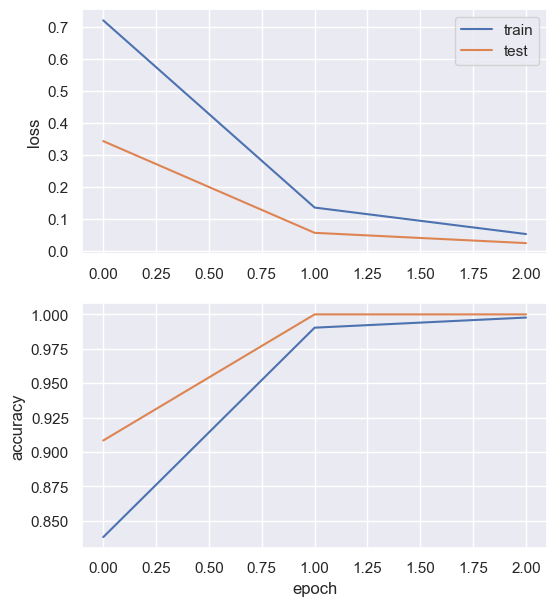

In [14]:
_, axes = plt.subplots(2, 1, figsize=(6, 7))
epochs = torch.arange(len(train_losses))  # noqa

axes[0].plot(epochs, train_losses)  # noqa
axes[0].plot(epochs, test_losses)  # noqa
axes[0].set_ylabel("loss")
axes[0].legend(["train", "test"])

axes[1].plot(epochs, train_accuracy)  # noqa
axes[1].plot(epochs, test_accuracy)  # noqa
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("accuracy")

In [15]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader, DEVICE)
y_true, y_pred = y_true.cpu(), y_pred.argmax(1).cpu()

Еще раз убедимся, что модель не ошибается:

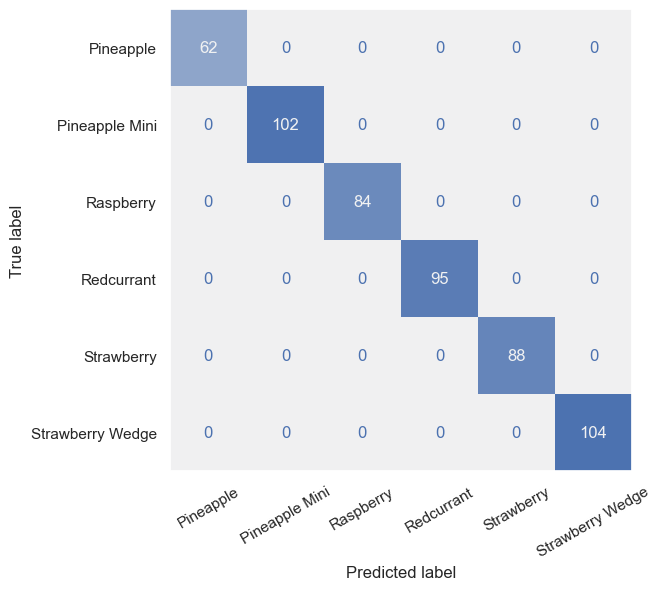

In [16]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=fruits_dataset.classes,
    colorbar=False,
    xticks_rotation=30,
    cmap=sns.color_palette('light:b', as_cmap=True)
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(6, 6)

И еще раз:

In [17]:
print(metrics.classification_report(y_true, y_pred, target_names=fruits_dataset.classes, zero_division=True))

                  precision    recall  f1-score   support

       Pineapple       1.00      1.00      1.00        62
  Pineapple Mini       1.00      1.00      1.00       102
       Raspberry       1.00      1.00      1.00        84
      Redcurrant       1.00      1.00      1.00        95
      Strawberry       1.00      1.00      1.00        88
Strawberry Wedge       1.00      1.00      1.00       104

        accuracy                           1.00       535
       macro avg       1.00      1.00      1.00       535
    weighted avg       1.00      1.00      1.00       535



Использование модели:

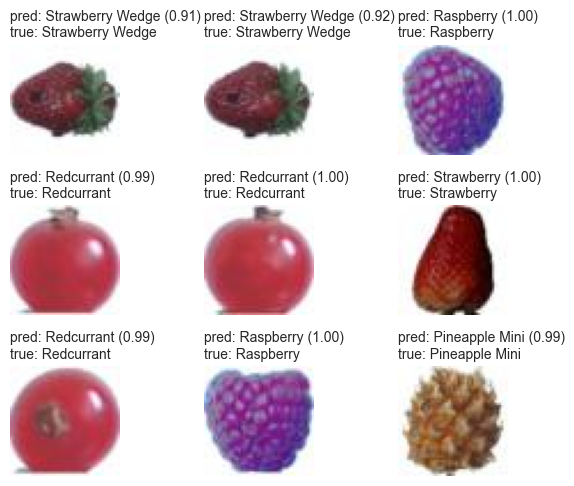

In [18]:
net.eval()

fig, axes = plt.subplots(3, 3, figsize=(6, 5))
fig.tight_layout()
for i, ax in zip(torch.randperm(len(test_dataset)), axes.flatten()):
    img, _ = fruits_dataset[test_dataset.indices[i]]  # картинка до нормализации

    x, target = test_dataset[i]
    pred = net(x.unsqueeze(0).to(DEVICE))

    pred_proba = torch.max(torch.softmax(pred, 1))
    pred_label = pred.argmax(1).item()
    ax.set_title(
        f"pred: {fruits_dataset.classes[pred_label]} ({pred_proba:.2f})"
        f"\ntrue: {fruits_dataset.classes[target]}", loc="left",
        fontdict={"fontsize": 10},
    )
    ax.axis("off")
    if img.mode == "RGB":
        ax.imshow(img)
    else:
        ax.imshow(img, cmap="gray")

### Вывод

Построена и обучена сверточная нейронная сеть с двумя сверточными слоями и простым линейным классификатором.

Модель отлично справляется с поставленной задачей. Вероятно повезло с датасетом. Попробовать усомниться в качестве модели можно с помощью кросс-валидации.

## Задание 3

Найти минимум функции: $ y = -\sqrt{16-4x-x^2} $ на отрезке $ [-7, 7] $

In [19]:
plt.rcParams["figure.figsize"] = (3.5, 2.5)

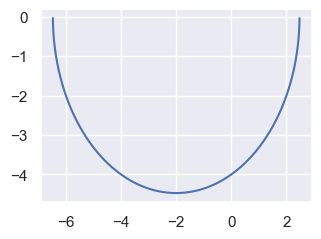

In [20]:
def f(x: torch.Tensor) -> torch.Tensor:
    return -torch.sqrt(16 - 4 * x - x * x)


START, END = -7, 7
EPS = 0.0000001
LR = 0.05

X = torch.arange(START, END + 0.001, 0.001)
Y = f(X)
plt.plot(X.detach(), Y.detach());

Решим с помощью алгоритма градиентного спуска:

In [21]:
def gradient_descent(
        func,
        interval: t.Tuple[float, float],
        eps: float,
        lr: float,
        initial_state: float = None,
) -> t.Tuple[torch.Tensor, t.List[torch.Tensor]]:
    """Градиентный спуск"""
    start, end = interval
    interval_eps = lr * (end - start)  # наивное расширение границ интервала
    adj_start, adj_end = start - interval_eps, end + interval_eps

    x = torch.tensor(initial_state, dtype=torch.float, requires_grad=True)

    i, n = 0, 1000
    with tqdm() as pbar:
        xs = []
        while True:
            xs.append(x.detach().clone())

            # обработка краевого случая
            if not adj_start <= x <= adj_end:  # вышли за границу дальше дозволенного
                # искомый экстремум - предыдущая позиция или одна из границ
                start_t, end_t = torch.tensor(start), torch.tensor(end)
                if start <= xs[-2] <= end:  # могут быть проблемы с -2
                    _, x = min((func(xs[-2]), xs[-2]), (func(start_t), start_t), (func(end_t), end_t))
                else:
                    _, x = min((func(start_t), start_t), (func(end_t), end_t))
                xs.append(x.detach().clone())
                return xs[-1], xs

            y = func(x)
            y.backward()
            grad = x.grad.clone()
            x.grad.zero_()

            with torch.no_grad():
                x -= lr * grad
                if torch.abs(x - xs[-1]) <= eps:  # найден экстремум с необходимой точностью
                    xs.append(x.detach().clone())
                    return xs[-1], xs

            if i % n == 0:
                pbar.update(n)
            i += 1

2000it [00:00, 6406.20it/s]


Найден локальный минимум: x=-2.000010, f(x)=-4.472136


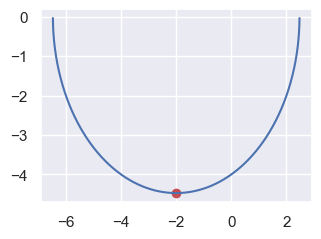

In [22]:
# initial_state = random.uniform(START, END)  # случайная инициализация - предпочтительно
initial_state = -6  # показательный пример
x, xs = gradient_descent(func=f, interval=(START, END), eps=EPS, lr=LR, initial_state=initial_state)
x, y = x.item(), f(x).item()
print(f"Найден локальный минимум: {x=:5f}, f(x)={y:5f}")
plt.plot(X.detach(), Y.detach())
plt.scatter(x, y, color="r");

Продемонстрирую процесс оптимизации:

In [ ]:
limit, delay = 500, 10
xs_ = xs.copy()
delayed = xs_[-1]
if len(xs_) > limit:
    xs_ = xs_[::len(xs_) // limit]
for i in range(delay):
    xs_.append(delayed)

with tqdm(total=len(xs_) + 1) as pbar:
    def animate(i):
        scatter.set_data(xs_[i].detach(), f(xs_[i]).detach())
        pbar.update()


    fig, ax = plt.subplots(1, 1)
    ax.plot(X.detach(), Y.detach())
    scatter, = ax.plot([], [], marker="o", color="r")
    anim = animation.FuncAnimation(fig, animate, interval=1, frames=len(xs_))
    anim.save("task_3.gif", writer="pillow", fps=20)
    plt.close()

 13%|█▎        | 73/568 [00:03<00:20, 23.78it/s]

![](task_3.gif)

Вместо градиентного спуска (реализованного вручную), можно использовать любой алгоритм оптимизации `pytorch.optim`:

In [ ]:
def torch_optimization(
        get_optimizer: t.Callable[[torch.Tensor], optim.Optimizer],
        func,
        interval: t.Tuple[float, float],
        eps: float,
        initial_state: float = None,
) -> t.Tuple[torch.Tensor, t.List[torch.Tensor]]:
    x = torch.tensor(initial_state, dtype=torch.float, requires_grad=True)

    optimizer = get_optimizer(x)
    lr = optimizer.param_groups[0]["lr"]

    start, end = interval
    interval_eps = lr * (end - start)
    adj_start, adj_end = start - interval_eps, end + interval_eps

    i, n = 0, 200
    with tqdm() as pbar:
        xs = []
        while True:
            xs.append(x.detach().clone())

            if not adj_start <= x <= adj_end:
                start_t, end_t = torch.tensor(start), torch.tensor(end)
                if start <= xs[-2] <= end:
                    _, x = min((func(xs[-2]), xs[-2]), (func(start_t), start_t), (func(end_t), end_t))
                else:
                    _, x = min((func(start_t), start_t), (func(end_t), end_t))
                xs.append(x.detach().clone())
                return xs[-1], xs

            y = func(x)
            optimizer.zero_grad()
            y.backward()
            optimizer.step()

            if torch.abs(x - xs[-1]) <= eps:
                xs.append(x.detach().clone())
                return xs[-1], xs

            if i % n == 0:
                pbar.update(n)
            i += 1

Например, Adam:

In [ ]:
x, xs = torch_optimization(
    get_optimizer=lambda x: optim.Adam([x], lr=LR),
    func=f,
    interval=(START, END),
    eps=EPS,
    initial_state=-5,
)
x, y = x.item(), f(x).item()
print(f"Найден локальный минимум: {x=:5f}, f(x)={y:5f}")
plt.plot(X.detach(), Y.detach())
plt.scatter(x, y, color="r");